In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import time
import datetime

<h2>DeepAR - Kaggle Bike Sharing Demand Dataset with Dynamic Features</h2>
<h4>Prepare Bike Rental Data for DeepAR training</h4>  
<quote>We will store the total rental count, registered rental count, and casual rental count data as a time series.</quote>
<quote>For each of the targets <b>total, registered, casual</b>, following JSON is structured as: Start Time, Array of target values, optional dynamic features and categories</quote>
<quote>Frequency of time series data (for example, hourly, daily, monthly and so forth) is specified using hyperparameter</quote>

<h4>To download original dataset, sign-in and download from this link: https://www.kaggle.com/c/bike-sharing-demand/data</h4>
<br>
<b>Dynamic features used</b>: ['season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed']<br>
       
Start Time From: ['datetime'] <br>
Target Feature: [<b>'count','registered','casual'</b>]<br>
Frequency: 'Hourly' <br>

Objective: <quote>You are provided hourly rental data spanning two years. For this competition, the training set is comprised of the first 19 days of each month, while the test set is the 20th to the end of the month. You must predict the total count of bikes rented during each hour covered by the test set, using only information available prior to the rental period (Ref: Kaggle.com)</quote>

In [18]:
dynamic_features = ['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp', 'humidity', 'windspeed']
target_values = ['count','registered','casual']

In [19]:
# Copy over from biketrain_data_preparation

freq='H' # Timeseries consists Hourly Data and we need to predict hourly rental count

# how far in the future predictions can be made
# 12 days worth of hourly forecast 
prediction_length = 288 

# aws recommends setting context same as prediction length as a starting point. 
# This controls how far in the past the network can see
context_length = 288

In [20]:
dt_predict_max = pd.Timestamp("2012-12-31 23:00:00") # 2012-12-31 23:00 alt way..pd.datetime(2012,12,31,23,0,0)

dt_dataset_start_time = pd.Timestamp("2011-01-01 00:00:00")
dt_dataset_end_time = pd.Timestamp("2012-12-19 23:00:00")

# use for model training
# Start time is the first row provided by kaggle
# Training TS end time ensures some data is withheld for model testing
# 12 days worth of training data is withheld for testing
dt_train_range = (dt_dataset_start_time,
                  dt_dataset_end_time - datetime.timedelta(hours=12*24) )

# Use entire data for testing
# We can compare predicted values vs actual (i.e. last 12 days is withheld for testing and model hasn't seen that data)
dt_test_range = (dt_dataset_start_time, 
                 dt_dataset_end_time) 

In [21]:
# Let's see if there are gaps in timesteps
def is_missing_steps(df,start,end,freq='D'):
    dt_range = pd.date_range(start=start,end=end,freq=freq)
    return not dt_range.equals(df.loc[start:end].index)

def get_missing_steps(df,start,end,freq='D'):
    dt_range = pd.date_range(start=start,end=end,freq=freq)
    return dt_range.difference(df.loc[start:end].index)    

# List timeseries with only NaNs
# They can be removed
def timeseries_with_only_nans(df):
    l = []
    for col in df.columns:
        if pd.isna(df[col].min()):
            #print (col)
            l.append(col)
    return l

In [22]:
df = pd.read_csv('train.csv', parse_dates=['datetime'],index_col=0)
df_test = pd.read_csv('test.csv', parse_dates=['datetime'],index_col=0)

In [23]:
# Dynamic Features for future bike count that needs to be predicted is available in two separate files
# train.csv = contains dynamic features for model training and evaluation (i.e. upto 19th of each month)
# test.csv = contains dynamic features for predictions that we need to submit to kaggle. (i.e from 20th to end of each month)
# For model training with dynamic features, we need to provide dynamic features for missing time steps

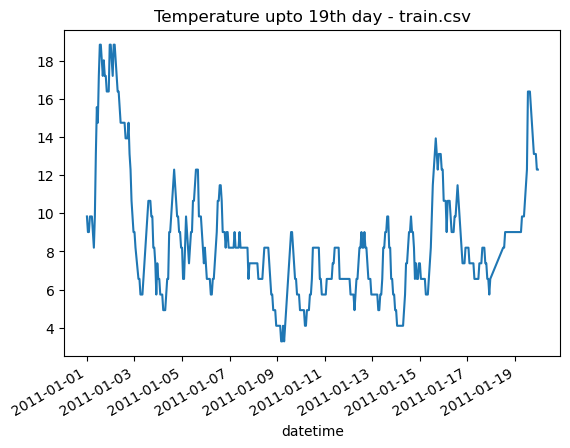

In [24]:
_=df.loc['2011-01']['temp'].plot(title='Temperature upto 19th day - train.csv')

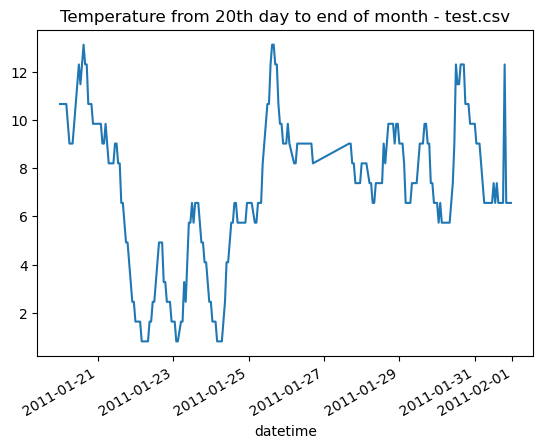

In [25]:
_=df_test.loc['2011-01']['temp'].plot(title='Temperature from 20th day to end of month - test.csv')

In [26]:
# Let's merge train.csv and test.csv files to a single dataframe
# This will allow dynamic features for missing time steps to populated from test.csv file
# NOTE: There are some missing time steps in test.csv as well...we need to handle it

In [27]:
df_test.loc['2011-01'].index.min(),df_test.loc['2011-01'].index.max()

(Timestamp('2011-01-20 00:00:00'), Timestamp('2011-01-31 23:00:00'))

In [28]:
# Check missing time steps in test.csv
get_missing_steps(df_test,'2011-01-20','2011-01-31','H')

DatetimeIndex(['2011-01-22 05:00:00', '2011-01-23 04:00:00',
               '2011-01-24 02:00:00', '2011-01-25 03:00:00',
               '2011-01-26 03:00:00', '2011-01-26 04:00:00',
               '2011-01-26 18:00:00', '2011-01-26 19:00:00',
               '2011-01-26 20:00:00', '2011-01-26 21:00:00',
               '2011-01-26 22:00:00', '2011-01-26 23:00:00',
               '2011-01-27 00:00:00', '2011-01-27 01:00:00',
               '2011-01-27 02:00:00', '2011-01-27 03:00:00',
               '2011-01-27 04:00:00', '2011-01-27 05:00:00',
               '2011-01-27 06:00:00', '2011-01-27 07:00:00',
               '2011-01-27 08:00:00', '2011-01-27 09:00:00',
               '2011-01-27 10:00:00', '2011-01-27 11:00:00',
               '2011-01-27 12:00:00', '2011-01-27 13:00:00',
               '2011-01-27 14:00:00', '2011-01-27 15:00:00',
               '2011-01-28 04:00:00', '2011-01-29 05:00:00',
               '2011-01-30 06:00:00'],
              dtype='datetime64[ns]', freq=Non

In [29]:
df.shape

(10886, 11)

In [30]:
# Let's append a new row with max predicted date
obj = {}
for col in df.columns:
    obj[col] = [np.nan]
    
df_temp = pd.DataFrame(obj,index=[dt_predict_max])
df = pd.concat([df,df_temp])

In [31]:
df.shape

(10887, 11)

In [32]:
# Resample entire data at 1 hour frequency
df = df.resample('1h').mean()

In [33]:
# dataset has these features set to NaN
df.tail()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
2012-12-31 19:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-12-31 20:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-12-31 21:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-12-31 22:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-12-31 23:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [34]:
# test file has features available for some of the time steps
df_test.tail()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
datetime,,,,,,,,
2012-12-31 19:00:00,1,0,1,2,10.66,12.880,60,11.0014
2012-12-31 20:00:00,1,0,1,2,10.66,12.880,60,11.0014
2012-12-31 21:00:00,1,0,1,1,10.66,12.880,60,11.0014
2012-12-31 22:00:00,1,0,1,1,10.66,13.635,56,8.9981
2012-12-31 23:00:00,1,0,1,1,10.66,13.635,65,8.9981


In [35]:
# Let's update data from test
df.update(df_test)

In [36]:
# Now we have data for dynamic features
df.tail()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
2012-12-31 19:00:00,1.0,0.0,1.0,2.0,10.66,12.880,60.0,11.0014,NaN,NaN,NaN
2012-12-31 20:00:00,1.0,0.0,1.0,2.0,10.66,12.880,60.0,11.0014,NaN,NaN,NaN
2012-12-31 21:00:00,1.0,0.0,1.0,1.0,10.66,12.880,60.0,11.0014,NaN,NaN,NaN
2012-12-31 22:00:00,1.0,0.0,1.0,1.0,10.66,13.635,56.0,8.9981,NaN,NaN,NaN
2012-12-31 23:00:00,1.0,0.0,1.0,1.0,10.66,13.635,65.0,8.9981,NaN,NaN,NaN


In [37]:
# Every feature has NaN (missing values)
# We need to fill in these missing features
df.isna().any()

season        True
holiday       True
workingday    True
weather       True
temp          True
atemp         True
humidity      True
windspeed     True
casual        True
registered    True
count         True
dtype: bool

In [38]:
# Let's look at some missing steps
# Jan 2011
get_missing_steps(df_test,'2011-01-20','2011-01-31','H')

DatetimeIndex(['2011-01-22 05:00:00', '2011-01-23 04:00:00',
               '2011-01-24 02:00:00', '2011-01-25 03:00:00',
               '2011-01-26 03:00:00', '2011-01-26 04:00:00',
               '2011-01-26 18:00:00', '2011-01-26 19:00:00',
               '2011-01-26 20:00:00', '2011-01-26 21:00:00',
               '2011-01-26 22:00:00', '2011-01-26 23:00:00',
               '2011-01-27 00:00:00', '2011-01-27 01:00:00',
               '2011-01-27 02:00:00', '2011-01-27 03:00:00',
               '2011-01-27 04:00:00', '2011-01-27 05:00:00',
               '2011-01-27 06:00:00', '2011-01-27 07:00:00',
               '2011-01-27 08:00:00', '2011-01-27 09:00:00',
               '2011-01-27 10:00:00', '2011-01-27 11:00:00',
               '2011-01-27 12:00:00', '2011-01-27 13:00:00',
               '2011-01-27 14:00:00', '2011-01-27 15:00:00',
               '2011-01-28 04:00:00', '2011-01-29 05:00:00',
               '2011-01-30 06:00:00'],
              dtype='datetime64[ns]', freq=Non

In [39]:
# Dec 2012
get_missing_steps(df_test,'2012-12-20','2012-12-31','H')

DatetimeIndex(['2012-12-24 04:00:00', '2012-12-25 03:00:00'], dtype='datetime64[ns]', freq=None)

In [41]:
df.loc['2011-01-26']

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
2011-01-26 00:00:00,1.0,0.0,1.0,2.0,9.02,11.365,69.0,8.9981,NaN,NaN,NaN
2011-01-26 01:00:00,1.0,0.0,1.0,2.0,9.84,12.120,65.0,8.9981,NaN,NaN,NaN
2011-01-26 02:00:00,1.0,0.0,1.0,3.0,9.02,11.365,69.0,12.9980,NaN,NaN,NaN
2011-01-26 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-26 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-26 05:00:00,1.0,0.0,1.0,3.0,8.20,9.090,86.0,19.0012,NaN,NaN,NaN
2011-01-26 06:00:00,1.0,0.0,1.0,3.0,8.20,9.090,86.0,19.0012,NaN,NaN,NaN
2011-01-26 07:00:00,1.0,0.0,1.0,3.0,9.02,10.605,87.0,19.9995,NaN,NaN,NaN
2011-01-26 08:00:00,1.0,0.0,1.0,3.0,9.02,10.605,87.0,19.9995,NaN,NaN,NaN
2011-01-26 09:00:00,1.0,0.0,1.0,3.0,9.02,10.605,87.0,19.9995,NaN,NaN,NaN


In [42]:
df.loc['2012-12-24']

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
2012-12-24 00:00:00,1.0,0.0,1.0,1.0,9.02,13.635,69.0,0.0000,NaN,NaN,NaN
2012-12-24 01:00:00,1.0,0.0,1.0,1.0,9.02,13.635,69.0,0.0000,NaN,NaN,NaN
2012-12-24 02:00:00,1.0,0.0,1.0,1.0,8.20,12.880,75.0,0.0000,NaN,NaN,NaN
2012-12-24 03:00:00,1.0,0.0,1.0,1.0,8.20,12.880,75.0,0.0000,NaN,NaN,NaN
2012-12-24 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-12-24 05:00:00,1.0,0.0,1.0,1.0,7.38,9.850,80.0,8.9981,NaN,NaN,NaN
2012-12-24 06:00:00,1.0,0.0,1.0,1.0,8.20,12.880,75.0,0.0000,NaN,NaN,NaN
2012-12-24 07:00:00,1.0,0.0,1.0,1.0,8.20,12.880,69.0,0.0000,NaN,NaN,NaN
2012-12-24 08:00:00,1.0,0.0,1.0,1.0,9.02,13.635,69.0,0.0000,NaN,NaN,NaN
2012-12-24 09:00:00,1.0,0.0,1.0,2.0,9.84,12.880,65.0,7.0015,NaN,NaN,NaN


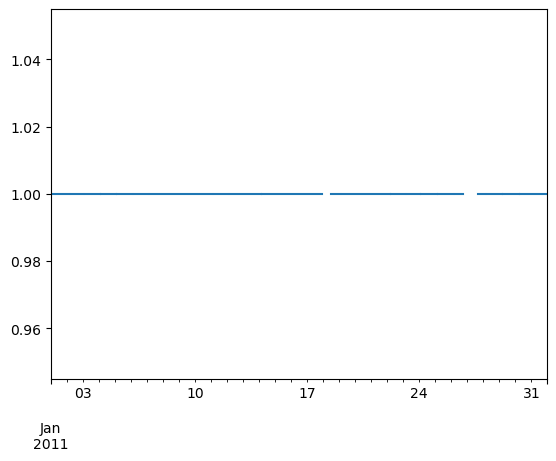

In [46]:
_=df.loc['2011-01', 'season'].plot()

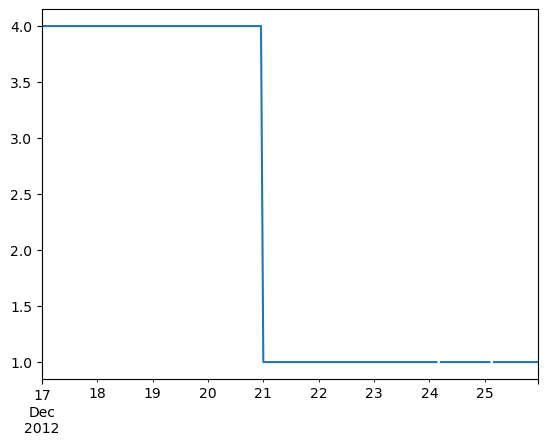

In [49]:
_=df.loc['2012-12-17':'2012-12-25','season'].plot()

In [51]:
# https://stackoverflow.com/questions/19966018/pandas-filling-missing-values-by-mean-in-each-group
# For these ['holiday','workingday','season'] columns, we simply need to look for another hour in the same day
# for which value is available and use it to fillna
# Holiday won't change hour to hour
# Holiday,Workingday and Season are the same for all hours of the day
group_ymd = df.loc[:,['holiday','workingday','season']].groupby([df.index.year,df.index.month,df.index.day])

for col in ['holiday','workingday','season']:
    print(col)
    df[col] = group_ymd[col].transform(lambda x: x.fillna(x.max()))

holiday
workingday
season


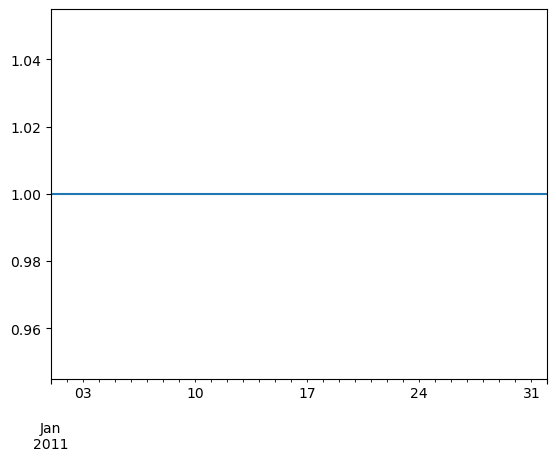

In [53]:
_=df.loc['2011-01','season'].plot()

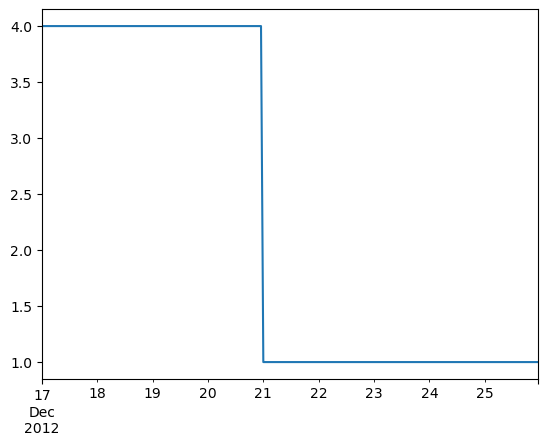

In [55]:
_=df.loc['2012-12-17':'2012-12-25', 'season'].plot()

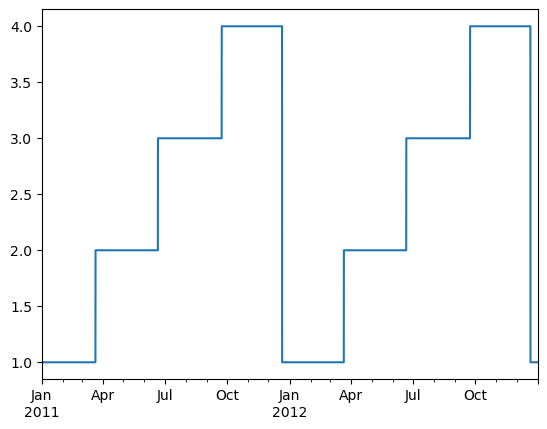

In [56]:
_ = df.loc[:,'season'].plot()

In [58]:
# Remaining NaN values in features, simply ffill
for col in ['weather', 'temp', 'atemp', 'humidity', 'windspeed']:
    df.loc[:,col] = df.loc[:,col].fillna(method='ffill')

In [60]:
df.loc['2011-01-26']

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
2011-01-26 00:00:00,1.0,0.0,1.0,2.0,9.02,11.365,69.0,8.9981,NaN,NaN,NaN
2011-01-26 01:00:00,1.0,0.0,1.0,2.0,9.84,12.120,65.0,8.9981,NaN,NaN,NaN
2011-01-26 02:00:00,1.0,0.0,1.0,3.0,9.02,11.365,69.0,12.9980,NaN,NaN,NaN
2011-01-26 03:00:00,1.0,0.0,1.0,3.0,9.02,11.365,69.0,12.9980,NaN,NaN,NaN
2011-01-26 04:00:00,1.0,0.0,1.0,3.0,9.02,11.365,69.0,12.9980,NaN,NaN,NaN
2011-01-26 05:00:00,1.0,0.0,1.0,3.0,8.20,9.090,86.0,19.0012,NaN,NaN,NaN
2011-01-26 06:00:00,1.0,0.0,1.0,3.0,8.20,9.090,86.0,19.0012,NaN,NaN,NaN
2011-01-26 07:00:00,1.0,0.0,1.0,3.0,9.02,10.605,87.0,19.9995,NaN,NaN,NaN
2011-01-26 08:00:00,1.0,0.0,1.0,3.0,9.02,10.605,87.0,19.9995,NaN,NaN,NaN
2011-01-26 09:00:00,1.0,0.0,1.0,3.0,9.02,10.605,87.0,19.9995,NaN,NaN,NaN


In [61]:
df.loc['2012-12-24']

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
2012-12-24 00:00:00,1.0,0.0,1.0,1.0,9.02,13.635,69.0,0.0000,NaN,NaN,NaN
2012-12-24 01:00:00,1.0,0.0,1.0,1.0,9.02,13.635,69.0,0.0000,NaN,NaN,NaN
2012-12-24 02:00:00,1.0,0.0,1.0,1.0,8.20,12.880,75.0,0.0000,NaN,NaN,NaN
2012-12-24 03:00:00,1.0,0.0,1.0,1.0,8.20,12.880,75.0,0.0000,NaN,NaN,NaN
2012-12-24 04:00:00,1.0,0.0,1.0,1.0,8.20,12.880,75.0,0.0000,NaN,NaN,NaN
2012-12-24 05:00:00,1.0,0.0,1.0,1.0,7.38,9.850,80.0,8.9981,NaN,NaN,NaN
2012-12-24 06:00:00,1.0,0.0,1.0,1.0,8.20,12.880,75.0,0.0000,NaN,NaN,NaN
2012-12-24 07:00:00,1.0,0.0,1.0,1.0,8.20,12.880,69.0,0.0000,NaN,NaN,NaN
2012-12-24 08:00:00,1.0,0.0,1.0,1.0,9.02,13.635,69.0,0.0000,NaN,NaN,NaN
2012-12-24 09:00:00,1.0,0.0,1.0,2.0,9.84,12.880,65.0,7.0015,NaN,NaN,NaN


In [62]:
# Now, only the rental count columns [count,registered,casual] should have NaN to indicate missing values
df.isna().any()

season        False
holiday       False
workingday    False
weather       False
temp          False
atemp         False
humidity      False
windspeed     False
casual         True
registered     True
count          True
dtype: bool

In [63]:
print(dynamic_features)

['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp', 'humidity', 'windspeed']


In [65]:
df_dynamic_feat = df.loc[:,dynamic_features]

In [66]:
df_dynamic_feat.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
2011-01-01 00:00:00,1.0,0.0,0.0,1.0,9.84,14.395,81.0,0.0
2011-01-01 01:00:00,1.0,0.0,0.0,1.0,9.02,13.635,80.0,0.0
2011-01-01 02:00:00,1.0,0.0,0.0,1.0,9.02,13.635,80.0,0.0
2011-01-01 03:00:00,1.0,0.0,0.0,1.0,9.84,14.395,75.0,0.0
2011-01-01 04:00:00,1.0,0.0,0.0,1.0,9.84,14.395,75.0,0.0


In [67]:
df_dynamic_feat.tail()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
2012-12-31 19:00:00,1.0,0.0,1.0,2.0,10.66,12.880,60.0,11.0014
2012-12-31 20:00:00,1.0,0.0,1.0,2.0,10.66,12.880,60.0,11.0014
2012-12-31 21:00:00,1.0,0.0,1.0,1.0,10.66,12.880,60.0,11.0014
2012-12-31 22:00:00,1.0,0.0,1.0,1.0,10.66,13.635,56.0,8.9981
2012-12-31 23:00:00,1.0,0.0,1.0,1.0,10.66,13.635,65.0,8.9981


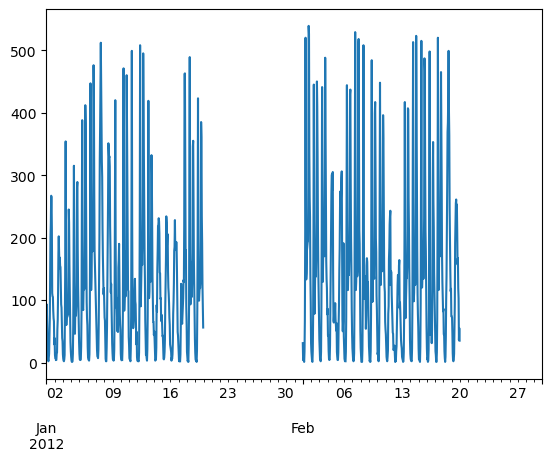

In [69]:
# Missing target values that we need to predict and fill
_=df.loc['2012-01':'2012-02']['count'].plot()

In [70]:
print(dt_train_range)
print(dt_test_range)

(Timestamp('2011-01-01 00:00:00'), Timestamp('2012-12-07 23:00:00'))
(Timestamp('2011-01-01 00:00:00'), Timestamp('2012-12-19 23:00:00'))


In [71]:
time_series_test = []
time_series_training = []

for t in target_values:
    time_series_test.append(df.loc[dt_test_range[0]:dt_test_range[1]][t])
    time_series_training.append(df.loc[dt_train_range[0]:dt_train_range[1]][t])

In [72]:
# Dynamic features are the same for count, registered, casual
dynamic_features_test = df_dynamic_feat.loc[dt_test_range[0]:dt_test_range[1]]
dynamic_features_training = df_dynamic_feat.loc[dt_train_range[0]:dt_train_range[1]]

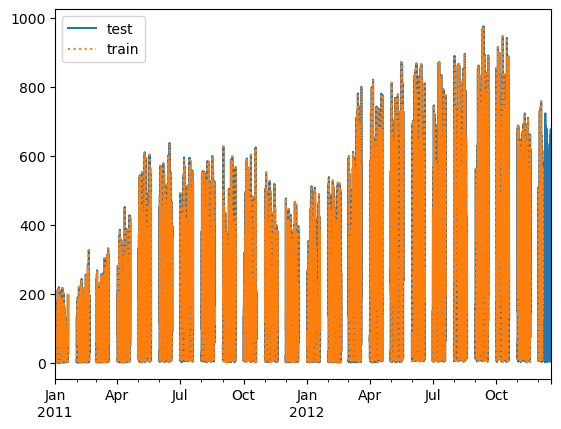

In [74]:
time_series_test[0].plot(label='test')
time_series_training[0].plot(label='train',ls="dotted")
plt.legend()
plt.show()

In [75]:
def encode_target(ts):
    return [x if np.isfinite(x) else "NaN" for x in ts]  

def encode_dynamic_feat(dynamic_feat):  
    l = []
    for col in dynamic_feat:
        assert (not dynamic_feat[col].isna().any()), col  + ' has NaN'             
        l.append(dynamic_feat[col].tolist())
    return l

def series_to_obj(ts, cat=None, dynamic_feat=None):
    obj = {"start": str(ts.index[0]), "target": encode_target(ts)}
    if cat is not None:
        obj["cat"] = cat
    if dynamic_feat is not None:
        obj["dynamic_feat"] = encode_dynamic_feat(dynamic_feat)
    return obj

def series_to_jsonline(ts, cat=None, dynamic_feat=None):
    return json.dumps(series_to_obj(ts, cat, dynamic_feat))   

In [76]:
series_to_jsonline(time_series_training[0][:5], dynamic_feat=dynamic_features_training[:5])

'{"start": "2011-01-01 00:00:00", "target": [16.0, 40.0, 32.0, 13.0, 1.0], "dynamic_feat": [[1.0, 1.0, 1.0, 1.0, 1.0], [0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 1.0, 1.0, 1.0, 1.0], [9.84, 9.02, 9.02, 9.84, 9.84], [14.395, 13.635, 13.635, 14.395, 14.395], [81.0, 80.0, 80.0, 75.0, 75.0], [0.0, 0.0, 0.0, 0.0, 0.0]]}'

In [77]:
encoding = "utf-8"
with open("train_dynamic_feat.json", 'wb') as fp:
    for ts in time_series_training:
        fp.write(series_to_jsonline(ts,dynamic_feat=dynamic_features_training).encode(encoding))
        fp.write('\n'.encode(encoding))

In [78]:
with open("test_dynamic_feat.json", 'wb') as fp:
    for ts in time_series_test:
        fp.write(series_to_jsonline(ts,dynamic_feat=dynamic_features_test).encode(encoding))
        fp.write('\n'.encode(encoding))

In [79]:
df.to_csv('all_data_dynamic_feat.csv',index=True,index_label='datetime')

In [80]:
for ts in time_series_test:
    print (len(ts),ts.name)

17256 count
17256 registered
17256 casual


In [81]:
for ts in time_series_training:
    print (len(ts),ts.name)

16968 count
16968 registered
16968 casual
